In the context of statistics and in particular machine learning, regularization is the name given to a process aimed primarily at reducing problems related to overfitting. And this, through a reduction of the variance or a selection of the number of parameters used. This process is not neutral since it consists of introducing new information to the problem, with the aim of "simplifying" it, either by introducing a penalty that increases as the complexity of the model increases or by "imposing" a prior distribution of the parameters of the model.

The general principle of regularization is to penalize extreme values ​​of parameters (which often leads to the overfitting variance). We then seek to minimize both the model with respect to our metric of choice as well as a metric on the size and the number of parameters used.

we will be focused on a family of regularization tools related to linear models, namely: ridge, lasso and elastic net. But there are obviously other tools suitable for other issues, we are thinking in particular of AIC/BIC (Akaike information criterion/Bayesian information criterion), PCR (Principal component regression), PLS (Partial least squares), LARS (Least- regression angle) and so on.

**BREAST CANCER DATASET - REGRESSION WITH FOCUS ON RIDGE LASSO AND ELASTIC NET METHODS**

In [1]:
#Importing libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import hvplot.pandas
%matplotlib inline

sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [2]:
#reading datafile already preprocessed

pcaData=pd.read_csv('pcaData.csv')
pcaData.head()

,id number,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Time
0,119513,-0.095361,-0.459349,0.166788,-0.194997,0.168222,0.152649,0.095757,0.241935
1,8423,0.835859,0.877988,-0.315062,0.397100,-0.309182,0.015621,-0.064614,0.483871
2,842517,0.216948,-0.044548,-0.398924,0.645883,0.038872,-0.208498,0.445940,0.927419
3,843483,-0.344805,1.991834,-0.066685,0.292337,0.062656,-0.122681,0.242864,0.983871
4,843584,0.366122,-0.218992,0.055548,0.307146,-0.429367,0.143614,-0.108283,0.209677


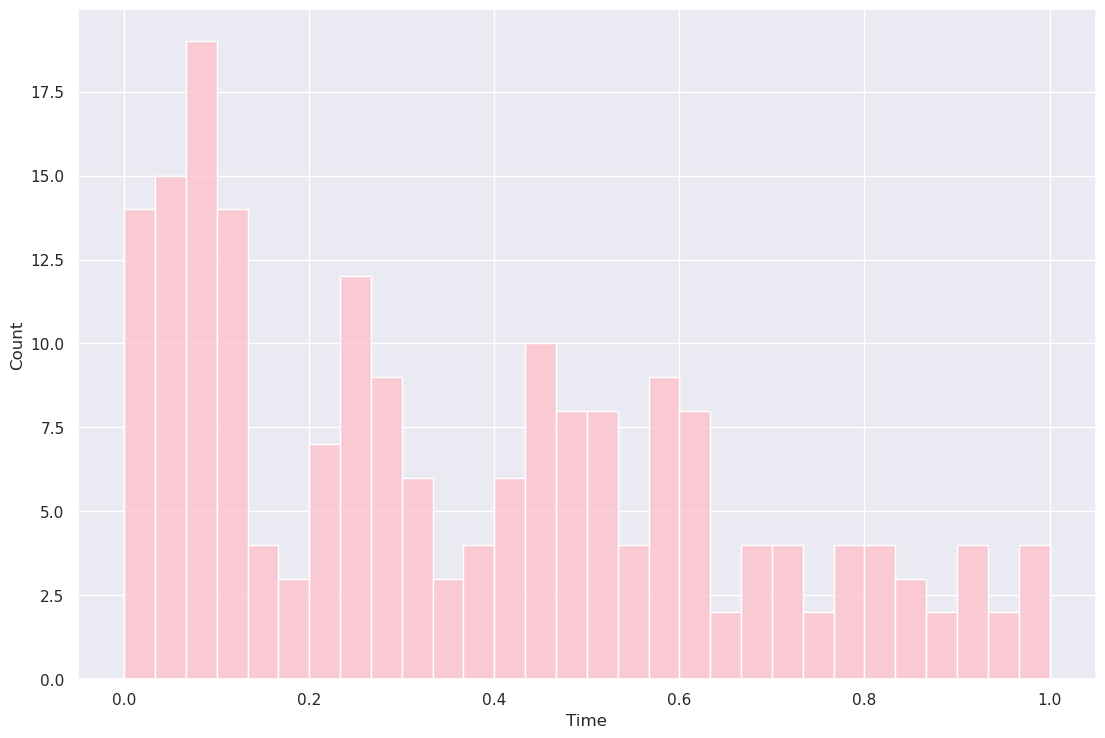

In [3]:
# set the size of the figure
sns.set(rc={'figure.figsize':(11.7,8.27)})
# plot a histogram showing the distribution of the target values
sns.histplot(pcaData['Time'], bins=30, color='pink')
plt.show()

<AxesSubplot:>

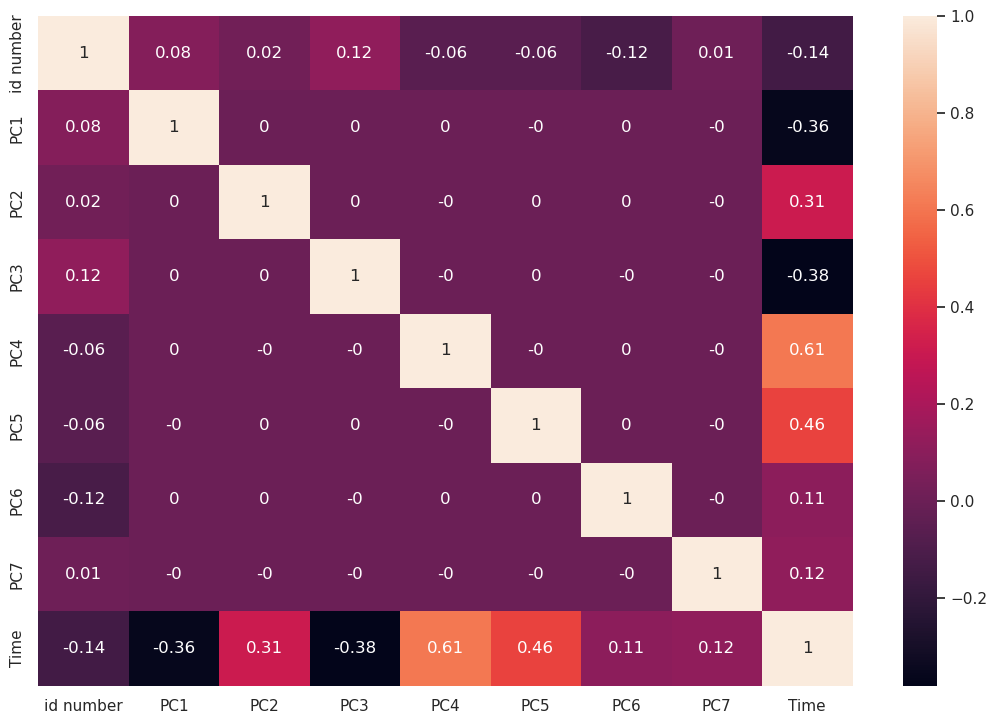

In [4]:
# compute the pair wise correlation for all columns
correlation_matrix = pcaData.corr().round(2)
# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [5]:
#define target and features
target = pcaData['Time'].values
features = pcaData.drop(['Time'], axis = 1)
#rename target and features
X = features
y = target

In [6]:
print(y.shape)
print(X.shape)
print(pcaData.shape)

(198,)
(198, 8)
(198, 9)


In [7]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape , X_test.shape

((158, 8), (40, 8))

## Regression Evaluation Metrics loss functions


Here are three common evaluation metrics for regression problems:

- **Mean Absolute Error** is the easiest to understand, because it's the average error. (MAE) is the mean of the absolute value of the errors:
$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

 - **Mean Squared Error**  is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
 (MSE) is the mean of the squared errors:
$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

- **Root Mean Squared Error** is even more popular than MSE, because RMSE is interpretable in the "y" units. (RMSE) is the square root of the mean of the squared errors:
$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$


In [8]:
#upload libraries for evaluation matrices calculation
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [9]:
#scaling data is important for linear regression so we use StandardScaler

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_Train = pipeline.fit_transform(X_train)
X_Test = pipeline.transform(X_test)

X_Train

array([[ 2.51474134, -1.07251517,  2.25271368, ..., -1.50067559,
        -0.00825619, -1.21974955],
       [-0.38448919, -1.01133507,  1.18045577, ..., -1.03271615,
         0.79241053, -0.94690874],
       [-0.37529652, -1.00165033,  1.6015079 , ..., -1.70617924,
        -2.34435561,  1.57586825],
       ...,
       [ 2.44275749, -1.1307418 ,  0.64556682, ..., -0.55147074,
         0.6901027 ,  0.68431585],
       [-0.35210034, -1.22792276, -1.80471422, ..., -0.2383177 ,
        -1.07164348,  0.23484046],
       [-0.65247255, -0.59687341, -0.43897422, ..., -0.28026724,
        -0.56445059, -0.59743693]])

**Cros Validation** is a statistical method of evaluating and comparing learning algorithms by dividing data into two segments: one used to learn or train a model and the other used to validate the model. In typical cross-validation, the training and validation sets must cross-over in successive rounds such that each data point has a chance of being validated against. 

**More about this in report**


In [10]:
#Defining function to do cross validation for each model

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

In [11]:
#define function to calculate optimal alpha value
def optimal_alpha(model):
    alpha = []
    error = []

    for i in range(1,100):
        alpha.append(i/100)
        model.set_params(alpha=i/100)
        model.fit(X_Train, y_train)
        pred_i = model.predict(X_Test)
        error.append(metrics.mean_squared_error(y_test, pred_i))

    return pd.DataFrame(list(zip(alpha, error)), columns=['alpha', 'error']).sort_values(by='error').head(1)



In [12]:
#define function to calcuate evaluation matrices for each model 

    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square


In [13]:
#print alredy evaluated matrices values

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')


In [14]:
#To have better idea we will vizualize our results
#Histogram of the predicted values and the actual values

def Histo_prediction_true(model):
    model.fit(X_Train, y_train)
    prediction = model.predict(X_Test)
    plt.figure(figsize=(10,5))
    sns.distplot(y_test, hist=True, kde=False, bins=30, color='pink')
    sns.distplot(prediction, hist=True, kde=False, bins=30, color='blue')
    plt.legend(labels=['Actual Values of time', 'Predicted Values of time'])
    plt.xlim(0,)

In [15]:
#this function will plot a scatter plot of the predicted values and the fit line for the test data

def Pred_Real_Model(model):
    model.fit(X_Train, y_train)
    prediction=model.predict(X_Test)
    x_ax = range(len(X_Test))
    plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
    plt.plot(x_ax, prediction, lw=0.8, color="red", label="predicted")
    plt.show()


In [16]:
def Fitfunction(model):
    # plotting the y_test vs y_pred
# ideally should have been a straight line
    model.fit(X_Train, y_train)
    prediction = model.predict(X_Test)
    plt.scatter(y_test, prediction, color='purple')
#add a line to show the perfect prediction
    plt.plot(y_test, y_test, color='red')
    plt.xlabel('Y Test')
    plt.ylabel('Predicted Y')
    
    plt.show()

In [17]:
#this is just for results interpretation

def Result(model):
    model.fit(X_Train, y_train)
    prediction = model.predict(X_Test)
    print(prediction)
    print('Predicted result:\n_____________________________________')

    print(np.dot(X,model.coef_) + model.intercept_)

# Ridge Regression

Source: [scikit-learn](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)
 Ridge regression addresses some of the problems of **Ordinary Least Squares** by imposing a penalty on the size of coefficients. The ridge coefficients minimize  a penalized residual sum of squares,

$$\min_{w}\big|\big|Xw-y\big|\big|^2_2+\alpha\big|\big|w\big|\big|^2_2$$

$\alpha>=0$ is a complexity parameter that controls the amount of shrinkage: the larger the value of $\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity.
 Ridge regression is an L2 penalized model. Add the squared sum of the weights to the least-squares cost function.

In [74]:
from sklearn.linear_model import Ridge

RidgeRegression = Ridge(alpha=0.99, solver='cholesky', tol=0.0001, random_state=42)

RidgeRegression.fit(X_Train, y_train)

test_predRR = RidgeRegression.predict(X_Test)
train_predRR = RidgeRegression.predict(X_Train)


results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_predRR) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])




print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_predRR)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_predRR)




Test set evaluation:
_____________________________________
MAE: 0.028317954063781004
MSE: 0.0014707501915178659
RMSE: 0.03835036103503937
R2 Square 0.9810723636044013
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.02356551336670286
MSE: 0.0009343612826955436
RMSE: 0.03056732377385275
R2 Square 0.9877723543866564
__________________________________


In [19]:
optimal_alpha(RidgeRegression)

,alpha,error
98,0.99,0.001471


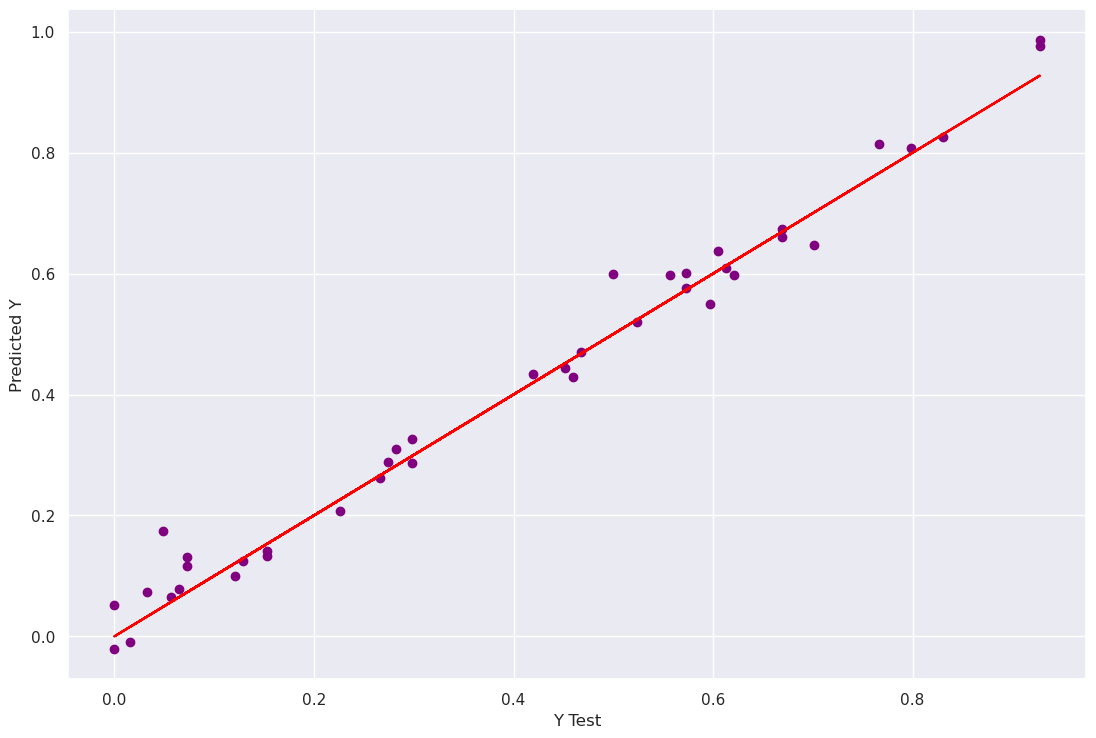

In [39]:
Fitfunction(RidgeRegression)

/tmp/ipykernel_11632/3460672857.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, hist=True, kde=False, bins=30, color='pink')
/tmp/ipykernel_11632/3460672857.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prediction, hist=True, kde=False, bins=30, color='blue')


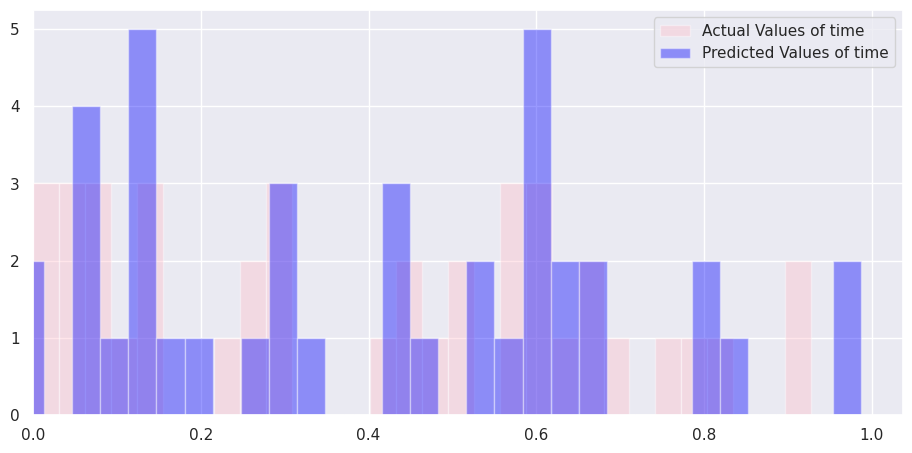

In [40]:
Histo_prediction_true(RidgeRegression)

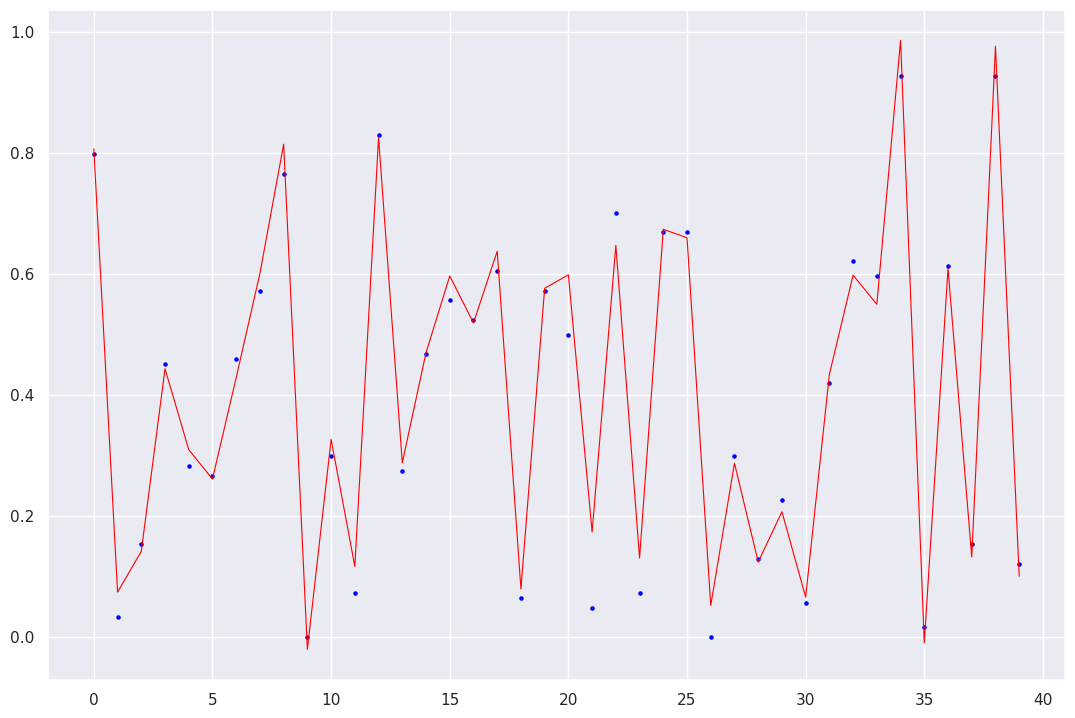

In [41]:
Pred_Real_Model(RidgeRegression)

# LASSO Regression

 A linear model that estimates sparse coefficients.

 Mathematically, it consists of a linear model trained with $\ell_1$ prior as regularizer. The objective function to minimize is:

$$\min_{w}\frac{1}{2n_{samples}} \big|\big|Xw - y\big|\big|_2^2 + \alpha \big|\big|w\big|\big|_1$$

 The lasso estimate thus solves the minimization of the least-squares penalty with $\alpha \big|\big|w\big|\big|_1$ added, where $\alpha$ is a constant and $\big|\big|w\big|\big|_1$ is the $\ell_1-norm$ of the parameter vector.


In [75]:
from sklearn.linear_model import Lasso

LAssoRgr = Lasso(alpha=0.01, 
              #precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)


LAssoRgr.fit(X_Train, y_train)

test_predLR = LAssoRgr.predict(X_Test)
train_predLR = LAssoRgr.predict(X_Train)



results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_predLR) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_predLR)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_predLR)

Test set evaluation:
_____________________________________
MAE: 0.12627970411592365
MSE: 0.022646560943140125
RMSE: 0.1504877434980674
R2 Square 0.7085529047593421
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.12110339372728467
MSE: 0.02368526613735039
RMSE: 0.15390018238244682
R2 Square 0.6900395532767217
__________________________________


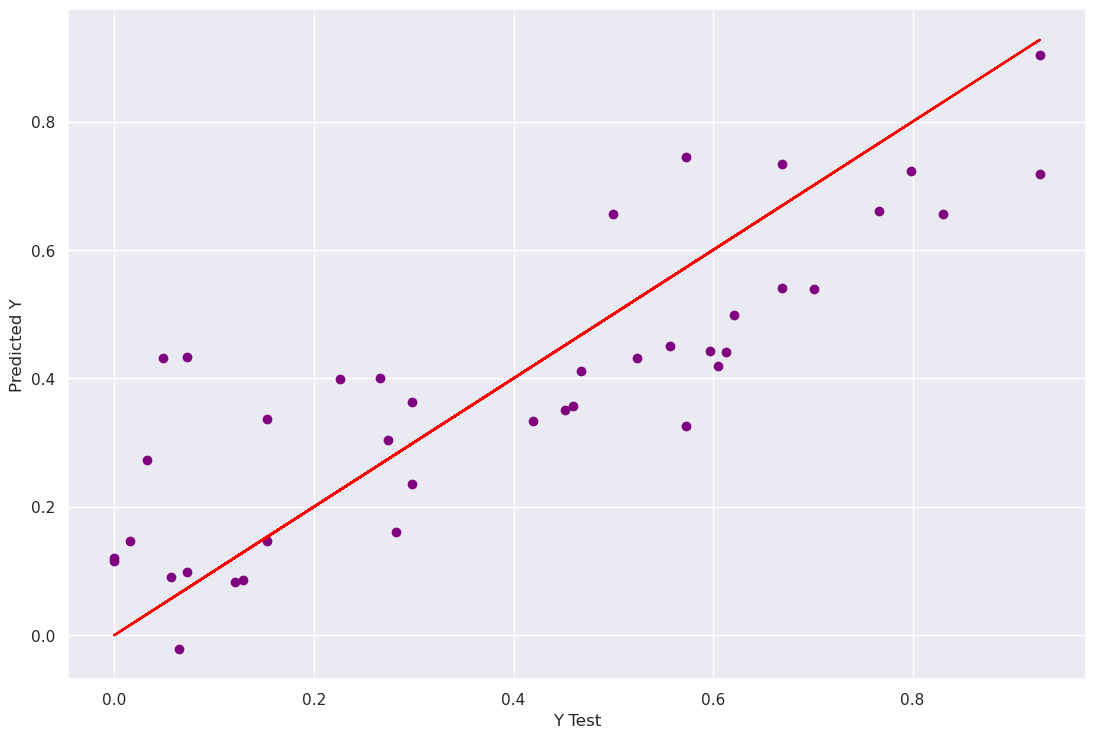

In [32]:
Fitfunction(LAssoRgr)

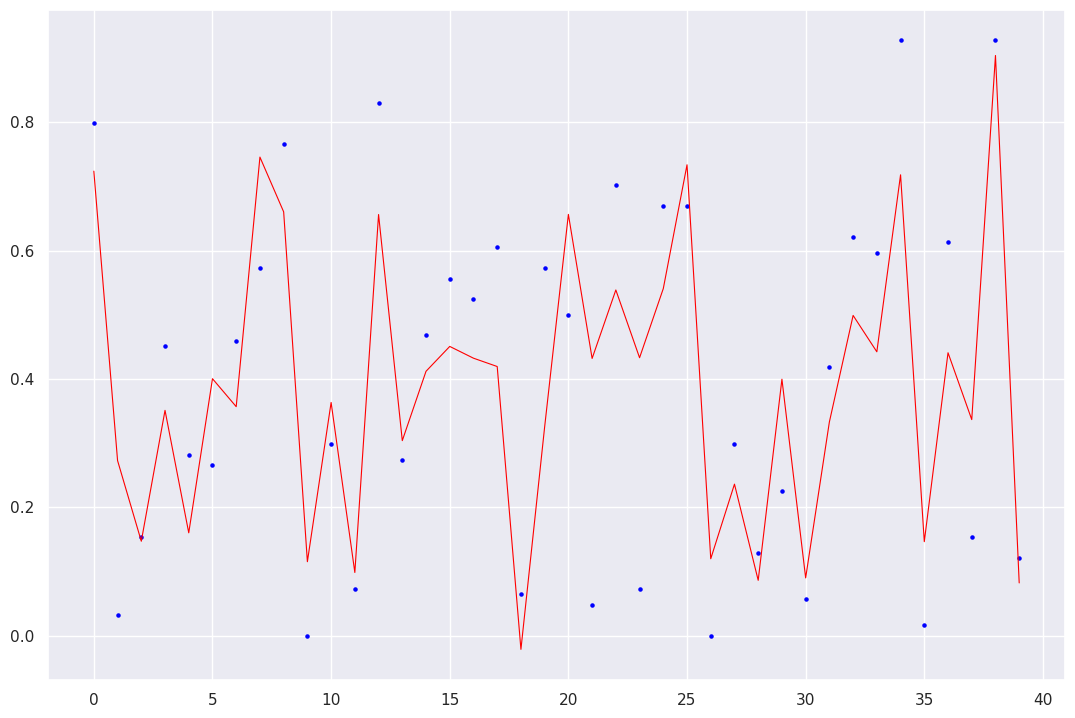

In [33]:
Pred_Real_Model(LAssoRgr)

/tmp/ipykernel_11632/3460672857.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, hist=True, kde=False, bins=30, color='pink')
/tmp/ipykernel_11632/3460672857.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prediction, hist=True, kde=False, bins=30, color='blue')


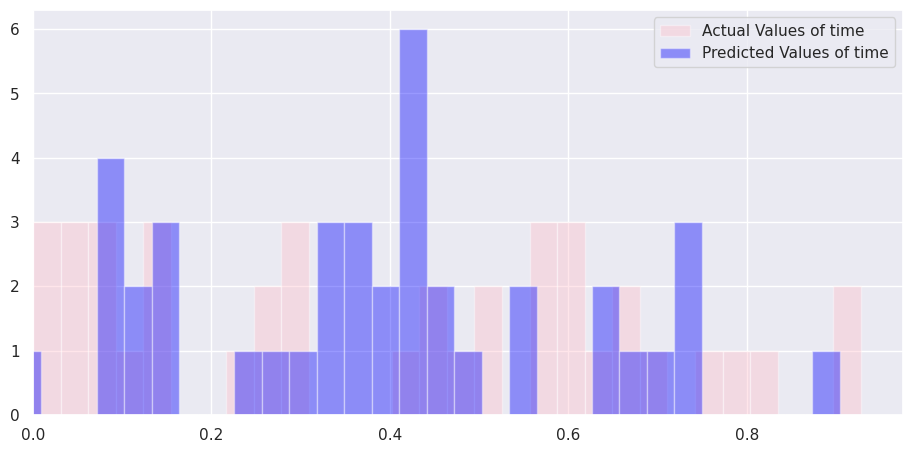

In [34]:
Histo_prediction_true(LAssoRgr)

In [35]:
optimal_alpha(LAssoRgr)

,alpha,error
0,0.01,0.022647


#  Elastic Net

 A linear regression model trained with L1 and L2 prior as regularizer. 
This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. 
 Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.
 A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.
 The objective function to minimize is in this case

$$\min_{w}{\frac{1}{2n_{samples}} \big|\big|X w - y\big|\big|_2 ^ 2 + \alpha \rho \big|\big|w\big|\big|_1 +
\frac{\alpha(1-\rho)}{2} \big|\big|w\big|\big|_2 ^ 2}$$

In [76]:
from sklearn.linear_model import ElasticNet

ElasticNetR = ElasticNet(alpha=0.01, l1_ratio=0.1, selection='random', random_state=42)
ElasticNetR.fit(X_Train, y_train)

test_predER = ElasticNetR.predict(X_Test)
train_predER = ElasticNetR.predict(X_Train)



results_df_2 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test, test_predER) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_predER)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_predER)



Test set evaluation:
_____________________________________
MAE: 0.02802559563374556
MSE: 0.0014838335861885482
RMSE: 0.03852056056430836
R2 Square 0.9809039884863323
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.024111338098805054
MSE: 0.0009574034323175894
RMSE: 0.030941936466833964
R2 Square 0.987470810171409
__________________________________


In [61]:
optimal_alpha(ElasticNetR)

,alpha,error
0,0.01,0.001484


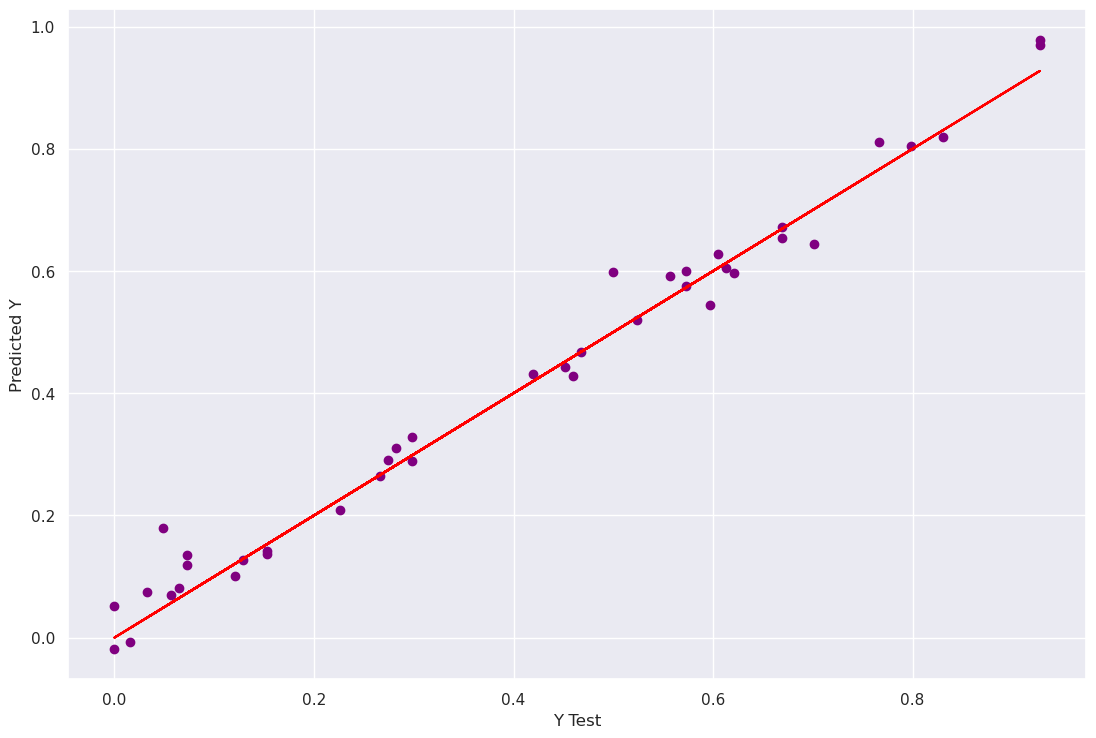

In [43]:
Fitfunction(ElasticNetR)

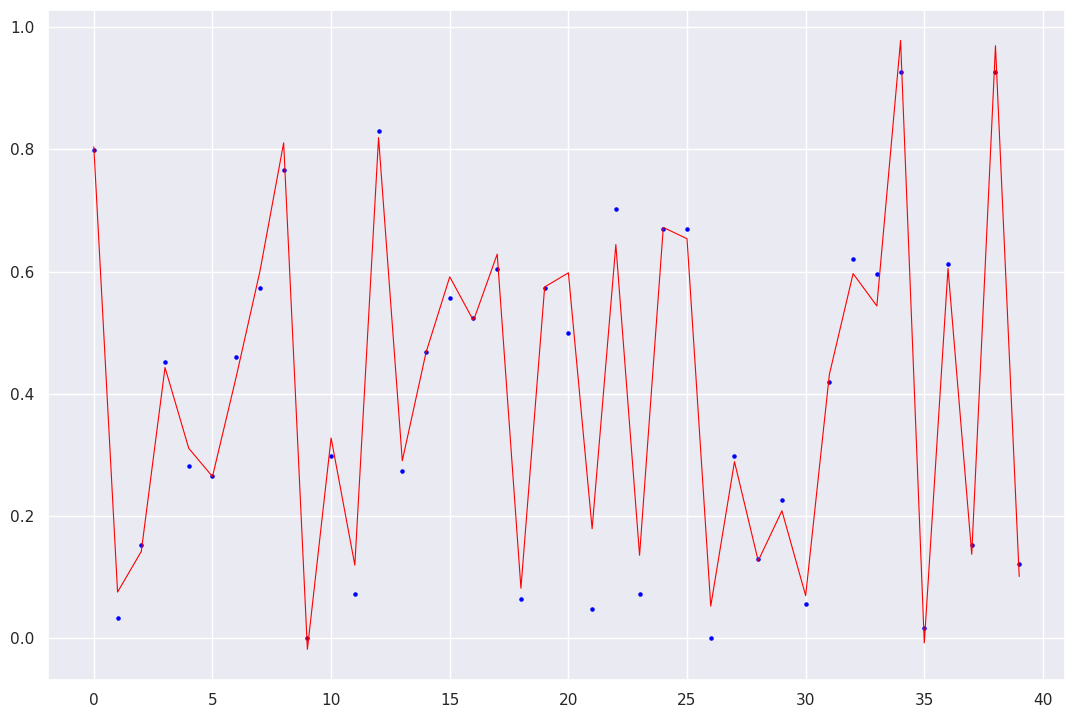

In [44]:
Pred_Real_Model(ElasticNetR)

/tmp/ipykernel_11632/3460672857.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, hist=True, kde=False, bins=30, color='pink')
/tmp/ipykernel_11632/3460672857.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prediction, hist=True, kde=False, bins=30, color='blue')


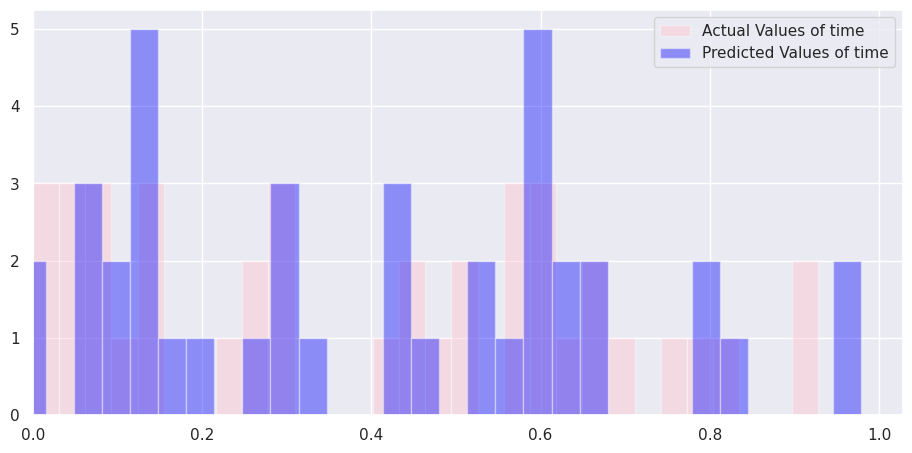

In [45]:
Histo_prediction_true(ElasticNetR)

In [77]:
#linear regression with gaussian kernel

from sklearn.svm import SVR

SVR_gauss = SVR(kernel='rbf', C=100, gamma='auto')
SVR_gauss.fit(X_Train, y_train)

test_predSVR_gauss = SVR_gauss.predict(X_Test)
train_predSVR_gauss = SVR_gauss.predict(X_Train)


results_df_2 = pd.DataFrame(data=[["Linear Kernel", *evaluate(y_test, test_predSVR_gauss) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_predSVR_gauss)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_predSVR_gauss)


Test set evaluation:
_____________________________________
MAE: 0.09573426264780675
MSE: 0.01572578164941317
RMSE: 0.12540247864142548
R2 Square 0.7976190118394723
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.05513603027506933
MSE: 0.00436663897109841
RMSE: 0.06608054911317256
R2 Square 0.9428553870447516
__________________________________


In [60]:
#optimize C and gamma

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],

                }

grid = GridSearchCV(SVR(kernel='rbf'), param_grid, refit=True, verbose=3)
grid.fit(X_Train, y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.135 total time=   0.0s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.152 total time=   0.0s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.158 total time=   0.0s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.176 total time=   0.0s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.194 total time=   0.0s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.848 total time=   0.0s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.793 total time=   0.0s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.757 total time=   0.0s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.782 total time=   0.0s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.811 total time=   0.0s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.714 total time=   0.0s
[CV 2/5] END .................C=0.1, gamma=0.01

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             verbose=3)

In [78]:
#linear regression with gaussian kernel and l2 regularization

from sklearn.kernel_ridge import KernelRidge

KRR = KernelRidge(alpha=0.99, kernel='polynomial', degree=2, coef0=2.5)
KRR.fit(X_Train, y_train)

test_predKRR = KRR.predict(X_Test)
train_predKRR = KRR.predict(X_Train)



results_df_2 = pd.DataFrame(data=[["Kernel Ridge Regression", *evaluate(y_test, test_predKRR) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_predKRR)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_predKRR)



Test set evaluation:
_____________________________________
MAE: 0.028073407331878353
MSE: 0.0011807761339805174
RMSE: 0.03436242328446173
R2 Square 0.9848041486192032
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.019793904500581105
MSE: 0.0006350742086295806
RMSE: 0.025200678733509948
R2 Square 0.9916890152608909
__________________________________


In [63]:
optimal_alpha(KRR)

,alpha,error
98,0.99,0.001181


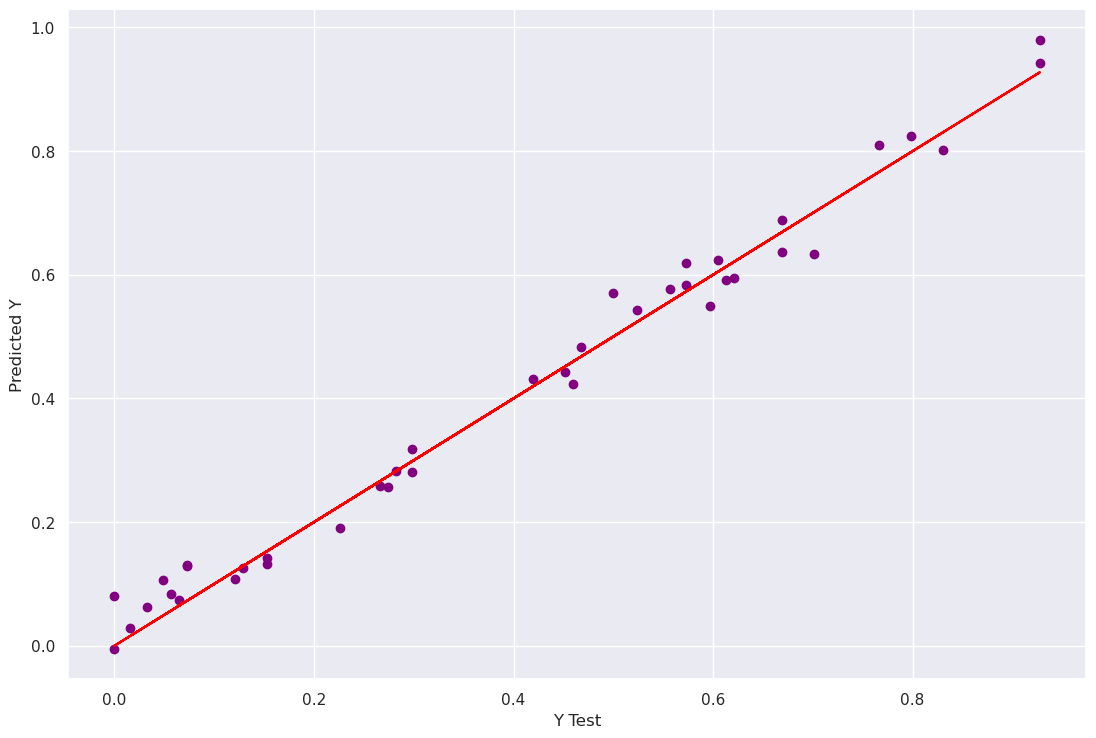

In [66]:
Fitfunction(KRR)

<AxesSubplot:ylabel='Model'>

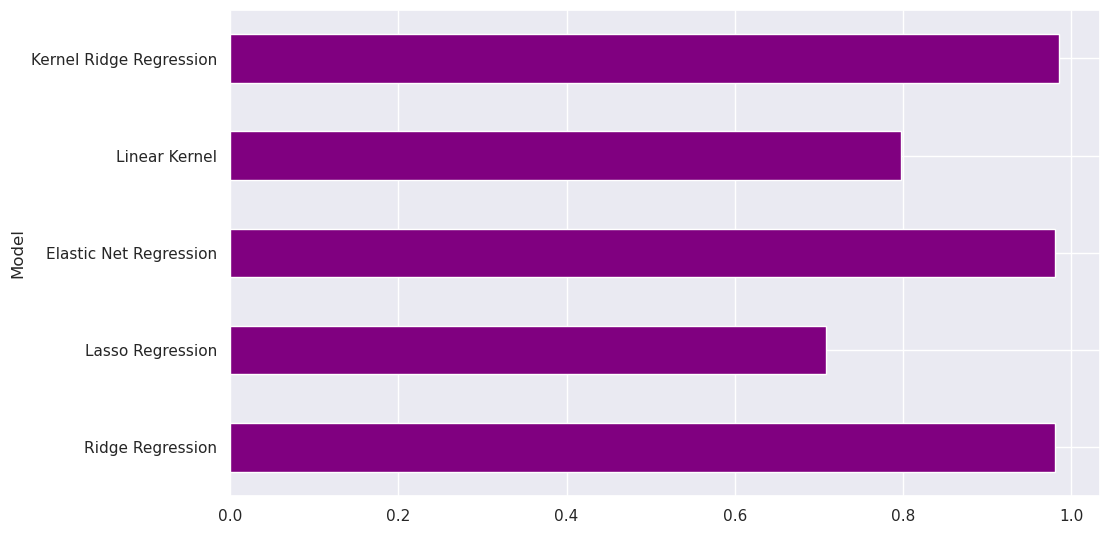

In [79]:

results_df.set_index('Model', inplace=True)
results_df['R2 Square'].plot(kind='barh', color='purple', figsize=(10, 6))


In [80]:
results_df

,MAE,MSE,RMSE,R2 Square,Cross Validation
Model,,,,,
Ridge Regression,0.028318,0.001471,0.038350,0.981072,0.803449
Lasso Regression,0.126280,0.022647,0.150488,0.708553,-9.461891
Elastic Net Regression,0.028026,0.001484,0.038521,0.980904,-9.461892
Linear Kernel,0.095734,0.015726,0.125402,0.797619,-9.461892
Kernel Ridge Regression,0.028073,0.001181,0.034362,0.984804,-9.461892
